In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import sys
import csv
import os
import gc

import torch.profiler

np.random.seed(1234)

In [2]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Should return an integer (GPU index)
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
0
NVIDIA GeForce GTX 1650


In [3]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# device = torch.device("cpu")
# print(device)

torch.backends.cudnn.benchmark = True

Using device: cuda


In [4]:
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        modules = []
        for i in range(len(layers) - 2):  # Exclude last layer for activation
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))  # Last layer (no activation)
        self.network = nn.Sequential(*modules)

        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)

In [5]:
w_pde = 1.0
w_bc = 1.0

E = 1.0
I = 1.0
L = 1.0
Q = -1.0

In [17]:
class PINN():
    def __init__(self, layers, x):

        self.x = x
        print(type(self.x), x.dtype)

        # DNN
        self.dnn = DNN(layers).to(device)

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=0.1,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-7,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"
        )

        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=0.01)
        self.iter = 0

    def model_value(self, x):
        out = self.dnn(x)
        u = out[:,0].view(-1, 1)
        m = out[:,1].view(-1, 1)
        return u, m
    
    def loss_func(self, x):
        u, m = self.model_value(x)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_2x = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

        m_x = torch.autograd.grad(m, x, torch.ones_like(m), create_graph=True)[0]
        m_2x = torch.autograd.grad(m_x, x, torch.ones_like(m_x), create_graph=True)[0]

        # BC
        bc_loss = torch.pow(u[0], 2) + torch.pow(u_x[0], 2)
        bc_loss += torch.pow(m[-1], 2) + torch.pow(m_x[-1], 2)

        # PDE
        pde_loss = torch.mean(torch.pow(E*I * m_2x + Q, 2))
        pde_loss += torch.mean(torch.pow(u_2x + m, 2))

        return pde_loss, bc_loss


    def lbfgs_func(self):
        pde_loss, bc_loss = self.loss_func(self.x)
        loss = w_pde*pde_loss + w_bc*bc_loss

        self.optimizer_lbfgs.zero_grad()
        loss.backward()

        if self.iter % 500 == 0:
            print(f"Iter: {self.iter}, PDE loss: {'{:e}'.format(pde_loss.item())}, BC loss: {'{:e}'.format(bc_loss.item())}")
        self.iter += 1
        return loss
    
    def train(self, epochs=1000):
        self.dnn.train()
        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func(self.x)
            loss = w_pde*pde_loss + w_bc*bc_loss

            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()

            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, PDE loss: {'{:e}'.format(pde_loss.item())}, BC loss: {'{:e}'.format(bc_loss.item())}")

        self.optimizer_lbfgs.step(self.lbfgs_func)

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device)

        self.dnn.eval()
        u, m = self.model_value(x)
        u = u.detach().cpu().numpy()
        m = m.detach().cpu().numpy()
        return u, m

In [7]:
# Remove model
def remove_model(model):
    del model
    gc.collect()
    torch.cuda.empty_cache()

# Parameters

# Exact solutions

In [8]:
x_hat = np.random.uniform(0, L, 100)
x_hat = np.append(x_hat, [0, L])
x_hat = np.sort(x_hat).reshape(-1, 1)

x_t = torch.tensor(x_hat, device=device, requires_grad=True).float()
layers = [1, 20, 20, 20, 2]

In [9]:
model = PINN(layers, x_t)
print(model.dnn)
next(model.dnn.parameters()).is_cuda

<class 'torch.Tensor'> torch.float32
DNN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=2, bias=True)
  )
)


True

In [10]:
%%time

model.train(2000)

Epoch: 0, PDE loss: 6.101598e-01, BC loss: 8.468750e-03
Epoch: 100, PDE loss: 2.042093e-02, BC loss: 1.379141e-03
Epoch: 200, PDE loss: 1.901655e-02, BC loss: 1.282040e-03
Epoch: 300, PDE loss: 2.079436e-02, BC loss: 5.842764e-03
Epoch: 400, PDE loss: 1.881547e-02, BC loss: 1.330592e-03
Epoch: 500, PDE loss: 1.880769e-02, BC loss: 1.324090e-03
Epoch: 600, PDE loss: 2.041978e-02, BC loss: 1.253325e-03
Epoch: 700, PDE loss: 1.880715e-02, BC loss: 1.319955e-03
Epoch: 800, PDE loss: 1.878904e-02, BC loss: 1.326637e-03
Epoch: 900, PDE loss: 1.877912e-02, BC loss: 1.328510e-03
Epoch: 1000, PDE loss: 1.877144e-02, BC loss: 1.330365e-03
Epoch: 1100, PDE loss: 1.884543e-02, BC loss: 1.280587e-03
Epoch: 1200, PDE loss: 1.877600e-02, BC loss: 1.330688e-03
Epoch: 1300, PDE loss: 1.876970e-02, BC loss: 1.331919e-03
Epoch: 1400, PDE loss: 1.876516e-02, BC loss: 1.332437e-03
Epoch: 1500, PDE loss: 1.863291e-02, BC loss: 1.655149e-03
Epoch: 1600, PDE loss: 1.877760e-02, BC loss: 1.331252e-03
Epoch: 17

In [11]:
def exact_solution(x):
    y = Q/(24*E*I)*(x**4 - 4*L*x**3 + 6*L**2*x**2)
    return y

(100, 1) (100,)
L2 Error: 8.179768777694727


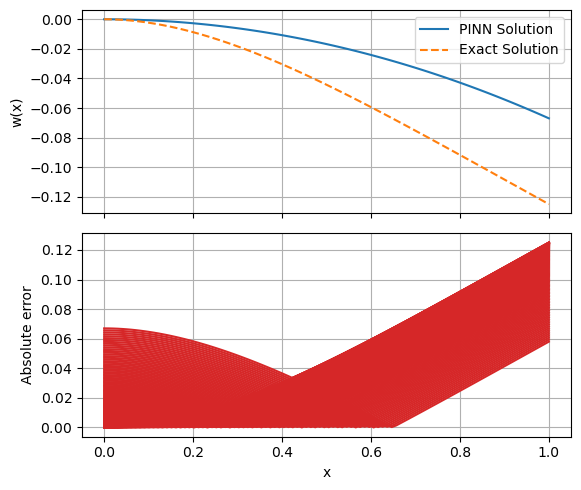

In [ ]:
x = np.linspace(0,L,100).reshape(-1, 1)

# Predict
u_pred, m_pred = model.predict(x)

# Exact
u_exact = exact_solution(x)

u_error = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact,2)
print(u_exact.shape, u_pred.shape)
abs_error = np.abs(u_pred - u_exact)
print(f"L2 Error: {u_error}")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True)

ax1.plot(x, u_pred, label="PINN Solution")
ax1.plot(x, u_exact, label="Exact Solution", linestyle="dashed")
ax1.set(ylabel='w(x)')
ax1.legend()
ax1.grid()

ax2.plot(x, abs_error, 'tab:red')
ax2.set(xlabel='x', ylabel='Absolute error')
ax2.grid()

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Defines when to switch to scientific notation

ax2.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()